In [1]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl
import wandb
wandb.init()

from src import *

wandb: Currently logged in as: lettera (use `wandb login --relogin` to force relogin)


In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 8    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

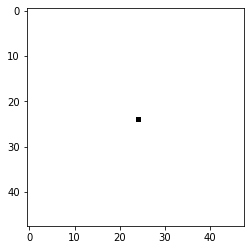

In [3]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

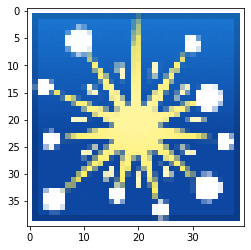

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Send target to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)

In [6]:
# Load the growing CA part
old_CA = NeuralCA(device=device)
old_CA.load("Pretrained_models/firework_growing.pt")

Successfully loaded model!


In [7]:
# Load the virus CA part
new_CA = NeuralCA(device=device)
new_CA.load("Pretrained_models/Virus 60%.pt")
model = VirusCA(old_CA, new_CA)

Successfully loaded model!


In [8]:
# Train the model
wandb.watch(model, log_freq=64)

for param in model.old_CA.parameters():
   param.requires_grad = False

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=1e-3)
criterion = NCALoss(pad(target, TARGET_PADDING))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=120, scheduler=scheduler, kind="persist")

KeyboardInterrupt: 

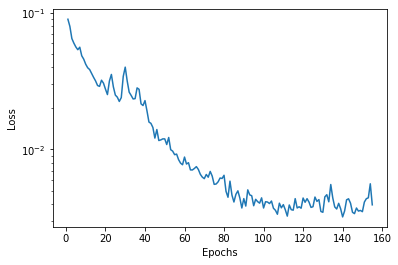

In [9]:
# Show losses
model.plot_losses()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


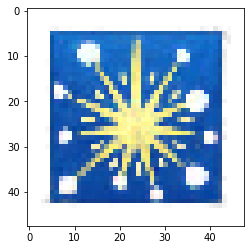

In [17]:
# Show a sample from the pool images
imshow(pool.sample(1)[0][0])

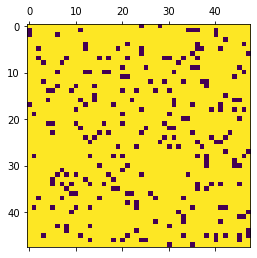

In [59]:
# Show the virus cell mask
pl.matshow(model.new_cells.cpu()[0,0])

In [46]:
# Make a video
_, _ = make_video(model, 150, generator(1, device), fname="prova.mp4")

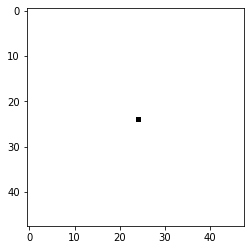

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


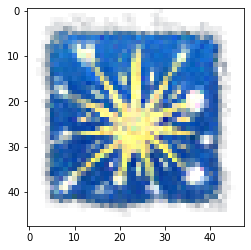

In [43]:
# Evolve the CA for 200 iters and plot it
x, _ = pool.sample(1)
imshow(x[0])
x = x.to(device)
model.update_cell_mask(x)

with torch.no_grad():
    for i in range(50):
        x = model.forward(x)

imshow(x[0].cpu())

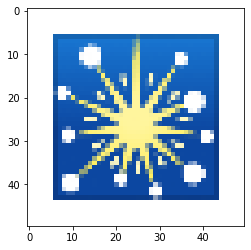

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))